In [27]:
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from datetime import datetime
from datetime import timedelta

## Load data

In [2]:
# Households
base_solar = osp.join('useful_solar', 'run_household_solar_1')
grid = osp.join(base_solar, 'gridbalance2016.csv')
solar = osp.join(base_solar, 'power2016_solar_module.csv')
household = osp.join(base_solar, 'power2016Household.csv')
griddata = pd.read_csv(grid, index_col=0)
solardata = pd.read_csv(solar)
householddata = pd.read_csv(household)

In [3]:
griddata.head(3)

,Time,Power from grid,Power into grid
0,0.000000,0.0,0.0
1,0.016667,0.0,0.0
2,0.033333,0.0,0.0


In [4]:
solardata

,Unnamed: 0,Time,Power consumed,Solar Power used
0,0,0.000000,0.0,0.0
1,1,0.016667,0.0,0.0
2,2,0.033333,0.0,0.0
3,3,0.050000,0.0,0.0
4,4,0.066667,0.0,0.0
5,5,0.083333,0.0,0.0
6,6,0.100000,0.0,0.0
7,7,0.116667,0.0,0.0
8,8,0.133333,0.0,0.0
9,9,0.150000,0.0,0.0


In [5]:
griddata['Power into grid'][:3000] + solardata['Solar Power used'][:3000]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       0.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
       ... 
2970    0.0
2971    0.0
2972    0.0
2973    0.0
2974    0.0
2975    0.0
2976    0.0
2977    0.0
2978    0.0
2979    0.0
2980    0.0
2981    0.0
2982    0.0
2983    0.0
2984    0.0
2985    0.0
2986    0.0
2987    0.0
2988    0.0
2989    0.0
2990    0.0
2991    0.0
2992    0.0
2993    0.0
2994    0.0
2995    0.0
2996    0.0
2997    0.0
2998    0.0
2999    0.0
Length: 3000, dtype: float64

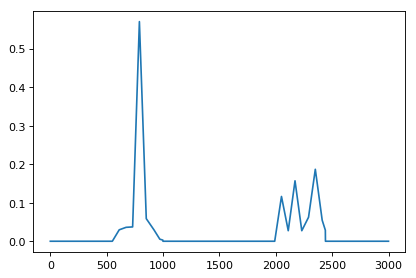

In [6]:
plt.figure(figsize=(6, 4), dpi=80)
total = griddata['Power into grid'][:3000] + solardata['Solar Power used'][:3000]
total.plot()
plt.show()

In [7]:
dt = [datetime(2016, 1, 1)]
for _ in range(len(total)-1): 
    dt.append(dt[-1] + timedelta(seconds=60))

total = total.to_frame()
total['date'] = dt

In [8]:
dt

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 1, 0, 1),
 datetime.datetime(2016, 1, 1, 0, 2),
 datetime.datetime(2016, 1, 1, 0, 3),
 datetime.datetime(2016, 1, 1, 0, 4),
 datetime.datetime(2016, 1, 1, 0, 5),
 datetime.datetime(2016, 1, 1, 0, 6),
 datetime.datetime(2016, 1, 1, 0, 7),
 datetime.datetime(2016, 1, 1, 0, 8),
 datetime.datetime(2016, 1, 1, 0, 9),
 datetime.datetime(2016, 1, 1, 0, 10),
 datetime.datetime(2016, 1, 1, 0, 11),
 datetime.datetime(2016, 1, 1, 0, 12),
 datetime.datetime(2016, 1, 1, 0, 13),
 datetime.datetime(2016, 1, 1, 0, 14),
 datetime.datetime(2016, 1, 1, 0, 15),
 datetime.datetime(2016, 1, 1, 0, 16),
 datetime.datetime(2016, 1, 1, 0, 17),
 datetime.datetime(2016, 1, 1, 0, 18),
 datetime.datetime(2016, 1, 1, 0, 19),
 datetime.datetime(2016, 1, 1, 0, 20),
 datetime.datetime(2016, 1, 1, 0, 21),
 datetime.datetime(2016, 1, 1, 0, 22),
 datetime.datetime(2016, 1, 1, 0, 23),
 datetime.datetime(2016, 1, 1, 0, 24),
 datetime.datetime(2016, 1, 1, 0, 2

In [9]:
total.set_index('date', drop=True, inplace=True)
total = total.resample('H').mean()

In [10]:
total.columns = ['PowerProduced']

In [11]:
total

,PowerProduced
date,
2016-01-01 00:00:00,0.000000
2016-01-01 01:00:00,0.000000
2016-01-01 02:00:00,0.000000
2016-01-01 03:00:00,0.000000
2016-01-01 04:00:00,0.000000
2016-01-01 05:00:00,0.000000
2016-01-01 06:00:00,0.000000
2016-01-01 07:00:00,0.000000
2016-01-01 08:00:00,0.000000


<Figure size 1080x576 with 0 Axes>

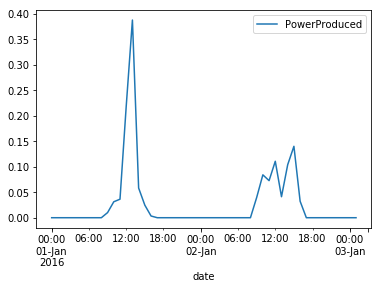

In [26]:
plt.figure(figsize=(15, 8))
# plt.plot(total.index, total[0])
total.plot()

In [ ]:
solardata = pd.read_csv(household)

In [ ]:
(solardata['Power consumed']/60).sum()

In [16]:
# for i in weather:
#     weather[i] = pd.to_numeric(weather[i])

In [19]:
cols = ['Irradiation', 'Wind', 'Diffuse', 'Direct']

## All users

In [21]:
# Households
base_solar = osp.join('useful_solar', 'run_household_solar_1')
grid = osp.join(base_solar, 'gridbalance2016.csv')
solar = osp.join(base_solar, 'power2016_solar_module.csv')
household = osp.join(base_solar, 'power2016Household.csv')
griddata = pd.read_csv(grid, index_col=0)
solardata = pd.read_csv(solar)
householddata = pd.read_csv(household)

In [61]:
solardata

,Unnamed: 0,Time,Power consumed,Solar Power used
0,0,0.000000,0.0,0.0
1,1,0.016667,0.0,0.0
2,2,0.033333,0.0,0.0
3,3,0.050000,0.0,0.0
4,4,0.066667,0.0,0.0
5,5,0.083333,0.0,0.0
6,6,0.100000,0.0,0.0
7,7,0.116667,0.0,0.0
8,8,0.133333,0.0,0.0
9,9,0.150000,0.0,0.0


In [69]:
pd.read_csv(osp.join(p, 'power2016_solar_module.csv'), index_col=0)

,Time,Power consumed,Solar Power used
0,0.000000,0.0,0.0
1,0.016667,0.0,0.0
2,0.033333,0.0,0.0
3,0.050000,0.0,0.0
4,0.066667,0.0,0.0
5,0.083333,0.0,0.0
6,0.100000,0.0,0.0
7,0.116667,0.0,0.0
8,0.133333,0.0,0.0
9,0.150000,0.0,0.0


In [72]:
production

NameError: name 'production' is not defined

In [78]:
pd.read_csv(osp.join(p, 'gridbalance2016.csv'), usecols=[3], index_col=0)

""
Power into grid
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [81]:
grid_balance.columns

Index([], dtype='object')

In [92]:
type(grid_balance['Power into grid'] + solar_module['Solar Power used'])

pandas.core.series.Series

In [85]:
# Read all folders and load the power consumption of all households into one frame
dfs = []
for p in glob.glob('useful_solar/*'):
    grid_balance = pd.read_csv(osp.join(p, 'gridbalance2016.csv'), usecols=[0, 3], index_col=0)
    solar_module = pd.read_csv(osp.join(p, 'power2016_solar_module.csv'), usecols=[0, 3], index_col=0)
    production = grid_balance['Power into grid'] + solar_module['Solar Power used']
    dfs.append(production.to_frame())

dfs = pd.concat(dfs, axis=1)
dfs.columns = ['production_h' + p.split('_')[-1] for p in glob.glob('useful_solar/*')]

In [97]:
dt = [datetime(2016, 1, 1)]
for _ in range(len(dfs)-1): 
    dt.append(dt[-1] + timedelta(seconds=60))

dfs['Date'] = dt
dfs.set_index('Date', drop=True, inplace=True)
dfs = dfs.resample('H').mean()

In [98]:
[ dfs[i] for i in dfs]

production_h1     1501.140169
production_h10    2724.370723
production_h11    2757.978879
production_h12    1829.591265
production_h13    2398.705701
production_h14    1843.152153
production_h15    2367.936558
production_h16    1642.194566
production_h17    2858.095338
production_h18    3520.826685
production_h19    1237.719387
production_h2     2398.705256
production_h20    1537.826699
production_h3     3379.767209
production_h4     3758.456668
production_h5     4954.210621
production_h6     3343.868636
production_h7     4667.840125
production_h8     1515.508322
production_h9     2156.279887
dtype: float64

In [94]:
dfs['TotalProduction'] = sum()

,production_h1,production_h10,production_h11,production_h12,production_h13,production_h14,production_h15,production_h16,production_h17,production_h18,production_h19,production_h2,production_h20,production_h3,production_h4,production_h5,production_h6,production_h7,production_h8,production_h9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Combined

In [58]:
weather = pd.read_csv("Weather-AMS/Climate240.csv", skiprows=27)[:8784]
weather.columns = [c.split(' ')[0] for c in weather.columns]
weather.Local = dfs.index
weather.set_index('Local', inplace=True, drop=True)
weather = weather.drop(columns=['ID'])
weather = weather.astype(float)

In [60]:
dfs

,consumed_h1,consumed_h10,consumed_h11,consumed_h12,consumed_h13,consumed_h14,consumed_h15,consumed_h16,consumed_h17,consumed_h18,consumed_h19,consumed_h2,consumed_h20,consumed_h3,consumed_h4,consumed_h5,consumed_h6,consumed_h7,consumed_h8,consumed_h9
Date,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.063509,0.074376,0.055113,0.055133,0.041821,0.070976,0.049510,0.258166,2.193508,0.051576,0.083876,0.022100,0.048513,0.255146,0.090316,0.527900,0.361613,0.147836,0.012741,0.044032
2016-01-01 01:00:00,0.052924,0.044626,0.055113,0.020048,0.038019,0.016185,0.059412,0.263448,1.769219,0.068768,0.052974,0.008840,0.026462,0.102579,0.085887,0.436551,0.028280,0.131515,0.014157,0.040431
2016-01-01 02:00:00,0.052924,0.004958,0.055113,0.045109,0.045623,0.017804,0.044559,0.066154,0.283120,0.057306,0.052974,0.035360,0.026462,0.081354,0.075878,0.106365,0.031422,0.131515,0.014157,0.030324
2016-01-01 03:00:00,0.063509,0.039667,0.060624,0.035085,0.045623,0.008093,0.044559,0.052816,0.125123,0.063037,0.013244,0.008840,0.044103,0.091026,0.080306,0.094852,0.018853,0.138430,0.015573,0.033693
2016-01-01 04:00:00,0.026462,0.069418,0.049601,0.055133,0.049425,0.118752,0.044559,0.058097,0.119255,0.057306,0.039731,0.015470,0.057334,0.082186,0.168475,0.138997,0.043990,0.057940,0.505252,0.033693
2016-01-01 05:00:00,0.031754,0.049584,0.066135,0.055133,0.034217,0.131165,0.064363,0.058097,0.103441,0.675832,0.044145,0.026520,0.039693,0.104111,0.350849,0.138447,0.006284,0.124600,0.721734,0.037062
2016-01-01 06:00:00,0.075087,0.080811,0.367831,0.096312,0.064733,0.157328,0.094486,0.086307,0.097017,0.818589,0.096837,0.055780,0.076963,0.132402,0.469299,0.808318,0.099798,0.220714,0.350092,0.078754
2016-01-01 07:00:00,0.068266,0.170533,0.385280,0.119852,0.431699,0.161124,0.081916,0.262001,0.309711,0.779683,0.259851,0.689453,0.209778,0.720303,0.463353,0.844549,0.389089,0.178480,0.227869,0.181562
2016-01-01 08:00:00,0.093877,0.712457,0.258320,0.312817,0.338672,0.161684,0.500596,0.321829,0.999753,0.334964,0.204328,0.282649,0.259930,0.503999,0.475786,1.114606,0.657110,0.576304,0.195798,0.341965


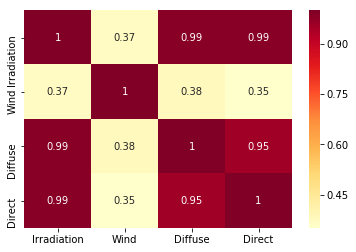

In [244]:
sns.heatmap(weather[cols].corr(), annot=True, cmap='YlOrRd')